If the model has overfiting symtoms. There are some solutions: 
- Reduce the number of variables
- Remove outliers
- Impute missing values
- Provide more training data
- Change model 
- Ridge and Lasso: Ridge (l2), Lasso (l1) 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV # gridsearch + cross validation 
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet
from sklearn.pipeline import Pipeline

In [156]:
data = load_diabetes()
features = data['feature_names']
X = data['data']
y = data['target']

In [157]:
df = pd.DataFrame(data=X, columns=features)
df.head(2)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=43)

### 1. Ridge (l2) 
$$
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{n} (y_i - \mathbf{x}_i^\top \mathbf{w})^2 + \lambda \|\mathbf{w}\|_2^2
$$

In [159]:
# Thay đổi alphas từ 0.1 --> 100
# Mẫu số trả về 200 số từ 10^1 -> 10^-2 ~ [10, ...., 0.01] => alpha ~ [0.1, 100]

n_alphas = 200
alphas = 1/np.logspace(1, -2, n_alphas) 
coefs = []

In [160]:
# train with multiple values of alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

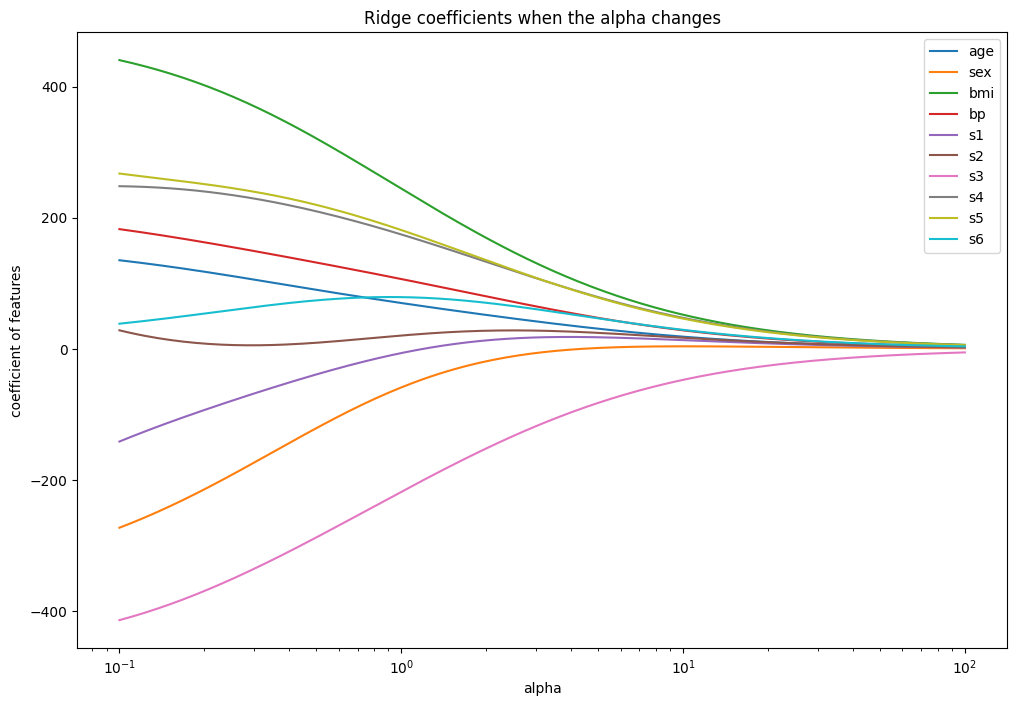

In [161]:

# Hiển thị kết quả mô hình cho các hệ số alpha 
fig, ax1 = plt.subplots(1,1, figsize=(12,8))  # fig, (ax1, ax2)d
#ax = plt.gca()
ax1.set_xscale('log')
ax1.plot(alphas, coefs)

plt.xlabel('alpha')
plt.ylabel('coefficient of features')
plt.title('Ridge coefficients when the alpha changes')
plt.axis('tight')
plt.legend(features, loc='upper right')

plt.show()



### 2. Lasso (l1)
$$
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{n} (y_i - \mathbf{x}_i^\top \mathbf{w})^2 + \alpha \|\mathbf{w}\|_1
$$


In [162]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso.coef_

array([   0.        , -102.60963348,  567.28690037,  191.16874898,
        -84.33615948,   -0.        , -204.52015001,    0.        ,
        509.35529527,   26.57668297])

In [163]:
# default alphas = np.logspace(-3, 3, 100), [10⁻³,10³]~(0.001 → 1000)
# auto select the best alpha value
reg_lasso_cv = LassoCV(cv=5, random_state=42) 
reg_lasso_cv.fit(X, y)

,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,5
,verbose,False
,n_jobs,None


In [164]:
print(reg_lasso_cv.coef_) # coef_ is a spare vector 
print(reg_lasso_cv.intercept_)
print(reg_lasso_cv.alpha_)


[  -6.49469328 -235.99308032  521.7443693   321.0607768  -569.43813385
  302.45319289   -0.          143.69851474  669.92267515   66.83551067]
152.133484162896
0.003753767152691846


### 3. Elastic Net
$$
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{n} (y_i - \mathbf{x}_i^\top \mathbf{w})^2 
+ \alpha \left( \lambda \|\mathbf{w}\|_1 + \frac{1 - \lambda}{2} \|\mathbf{w}\|_2^2 \right)
$$

In [165]:
regr = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
regr.fit(X_train, y_train)

,alpha,1.0
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [166]:
print(regr.coef_)
print(regr.intercept_)

[ 0.17170455  0.          3.31661245  1.75973881  0.35403392  0.05066019
 -1.84367011  2.22737825  3.09203277  1.69739908]
151.7303281254361


### 4. Tuning

In [ ]:
idx = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, test_size=.33, random_state=42)

test_fold = [-1 if i in idx_train else 0 for i in idx]
ps = PredefinedSplit(test_fold=test_fold)

### Lasso

In [ ]:
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])
param_grid = {'model__alpha': np.arange(1, 10, 1)}

# muon MSE min, nhung trong GridSearchCV dung ham max -> phai dung neg MSE
# verbose: hien thi chi tiet 
search_lasso = GridSearchCV(pipeline_lasso, param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=3)
search_lasso.fit(X, y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1] END ................model__alpha=1;, score=-2988.054 total time=   0.0s
[CV 1/1] END ................model__alpha=2;, score=-3023.197 total time=   0.0s
[CV 1/1] END ................model__alpha=3;, score=-3085.616 total time=   0.0s
[CV 1/1] END ................model__alpha=4;, score=-3165.829 total time=   0.0s
[CV 1/1] END ................model__alpha=5;, score=-3222.528 total time=   0.0s
[CV 1/1] END ................model__alpha=6;, score=-3252.821 total time=   0.0s
[CV 1/1] END ................model__alpha=7;, score=-3287.834 total time=   0.0s
[CV 1/1] END ................model__alpha=8;, score=-3327.556 total time=   0.0s
[CV 1/1] END ................model__alpha=9;, score=-3371.990 total time=   0.0s


,estimator,"Pipeline(step...l', Lasso())])"
,param_grid,"{'model__alpha': array([1, 2, ..., 6, 7, 8, 9])}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,"PredefinedSpl...shape=(442,)))"
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [ ]:
print(search_lasso.best_estimator_)
print(search_lasso.best_params_)
print(search_lasso.best_score_)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=np.int64(1)))])
{'model__alpha': np.int64(1)}
-2988.0535250026996


### Ridge

In [173]:
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
param_grid = {'model__alpha': np.arange(1, 10, 1)}

# muon MSE min, nhung trong GridSearchCV dung ham max -> phai dung neg MSE
# verbose: hien thi chi tiet 
search_ridge = GridSearchCV(pipeline_ridge, param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=3)
search_ridge.fit(X, y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1] END ................model__alpha=1;, score=-2971.716 total time=   0.0s
[CV 1/1] END ................model__alpha=2;, score=-2971.603 total time=   0.0s
[CV 1/1] END ................model__alpha=3;, score=-2972.318 total time=   0.0s
[CV 1/1] END ................model__alpha=4;, score=-2973.135 total time=   0.0s
[CV 1/1] END ................model__alpha=5;, score=-2973.887 total time=   0.0s
[CV 1/1] END ................model__alpha=6;, score=-2974.545 total time=   0.0s
[CV 1/1] END ................model__alpha=7;, score=-2975.118 total time=   0.0s
[CV 1/1] END ................model__alpha=8;, score=-2975.620 total time=   0.0s
[CV 1/1] END ................model__alpha=9;, score=-2976.068 total time=   0.0s


,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': array([1, 2, ..., 6, 7, 8, 9])}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,"PredefinedSpl...shape=(442,)))"
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [177]:
print(search_ridge.best_estimator_)
print(search_ridge.best_params_)
print(search_ridge.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Ridge(alpha=np.int64(2)))])
{'model__alpha': np.int64(2)}
-2971.6030618698105


In [180]:
pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])
param_grid = {
    'model__alpha': np.arange(1, 10, 1),
    'model__l1_ratio': [0.2, 0.5, 0.8]
    }

# muon MSE min, nhung trong GridSearchCV dung ham max -> phai dung neg MSE
# verbose: hien thi chi tiet 
search_elastic = GridSearchCV(pipeline_elastic, param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=3)
search_elastic.fit(X, y)

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1] END model__alpha=1, model__l1_ratio=0.2;, score=-3249.681 total time=   0.0s
[CV 1/1] END model__alpha=1, model__l1_ratio=0.5;, score=-3134.522 total time=   0.0s
[CV 1/1] END model__alpha=1, model__l1_ratio=0.8;, score=-3028.486 total time=   0.0s
[CV 1/1] END model__alpha=2, model__l1_ratio=0.2;, score=-3575.357 total time=   0.0s
[CV 1/1] END model__alpha=2, model__l1_ratio=0.5;, score=-3375.441 total time=   0.0s
[CV 1/1] END model__alpha=2, model__l1_ratio=0.8;, score=-3144.054 total time=   0.0s
[CV 1/1] END model__alpha=3, model__l1_ratio=0.2;, score=-3841.777 total time=   0.0s
[CV 1/1] END model__alpha=3, model__l1_ratio=0.5;, score=-3598.531 total time=   0.0s
[CV 1/1] END model__alpha=3, model__l1_ratio=0.8;, score=-3279.360 total time=   0.0s
[CV 1/1] END model__alpha=4, model__l1_ratio=0.2;, score=-4059.914 total time=   0.0s
[CV 1/1] END model__alpha=4, model__l1_ratio=0.5;, score=-3795.621 total time= 

,estimator,Pipeline(step...lasticNet())])
,param_grid,"{'model__alpha': array([1, 2, ..., 6, 7, 8, 9]), 'model__l1_ratio': [0.2, 0.5, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,"PredefinedSpl...shape=(442,)))"
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [181]:
print(search_elastic.best_estimator_)
print(search_elastic.best_params_)
print(search_elastic.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', ElasticNet(alpha=np.int64(1), l1_ratio=0.8))])
{'model__alpha': np.int64(1), 'model__l1_ratio': 0.8}
-3028.485767608698
